<a href="https://colab.research.google.com/github/nid-22/Automated_Ticket_Classification/blob/main/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [ ]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

In [ ]:
pd.set_option('display.max_colwidth', None)  # Show full cell contents


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
# Opening JSON file
root_path = '/content/drive/MyDrive/Colab Notebooks/NLP/automated_ticket_classification/complaints-2021-05-14_08_16.json'
f = open(root_path)

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [ ]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [ ]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [ ]:
#Assign new column names
df = df[['_source.complaint_what_happened','_source.product','_source.sub_product',]]

df = df.rename(columns={'_source.complaint_what_happened':'complaint_text', '_source.product':'product', '_source.sub_product':'sub_product'})

df.head()

,complaint_text,product,sub_product
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [ ]:
# product + sub_product can be one column where each unique combination is treated as a distinct “topic”

df['product'] = df['product'] + "-" + df['sub_product']
df.drop('sub_product', axis=1, inplace=True)
df.head()

,complaint_text,product
0,,Debt collection-Credit card debt
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Debt collection-Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Credit card or prepaid card-General-purpose credit card or charge card
3,,Mortgage-Conventional home mortgage
4,,Credit card or prepaid card-General-purpose credit card or charge card


In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   complaint_text  78313 non-null  object
 1   product         67742 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


,complaint_text,product
count,78313,67742
unique,20931,87
top,,Credit card or prepaid card-General-purpose credit card or charge card
freq,57241,10504


In [ ]:
df.complaint_text.isnull().sum()

np.int64(0)

In [ ]:
(df.complaint_text == "").sum()

np.int64(57241)

In [ ]:
#Assign nan in place of blanks in the complaints column
# Pandas recognizes np.nan as a "missing" entry, so functions like .isnull(), .fillna(), and .dropna() will detect and handle it automatically.
# If you just left the value as '' (empty string), pandas wouldn't treat it as "missing" — it’s still a valid string value.
df[df['complaint_text']==''] = np.nan

In [ ]:
df.isnull().sum()

,0
complaint_text,57241
product,59350


In [ ]:
#Remove all rows where complaints column is nan

# df.drop(df[df['complaint_text'].isna()],axis=0,inplace=True)
df.dropna(subset = 'complaint_text',inplace=True)

In [ ]:
df.isnull().sum()

,0
complaint_text,0
product,2109


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [ ]:
# function to clean the text and remove all the unnecessary elements.
def clean_text(text):
    text = text.lower()  # Make the text lowercase
    text = re.sub('\[.*\]','', text).strip() # Remove text in square brackets
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = re.sub('\S*\d\S*\s*','', text).strip()  # Remove words containing numbers
    return text.strip()

df.complaint_text =  df.complaint_text.apply(lambda x: clean_text(x))

<>:4: SyntaxWarning:

invalid escape sequence '\['

<>:6: SyntaxWarning:

invalid escape sequence '\S'

<>:4: SyntaxWarning:

invalid escape sequence '\['

<>:6: SyntaxWarning:

invalid escape sequence '\S'

/tmp/ipython-input-438886694.py:4: SyntaxWarning:

invalid escape sequence '\['

/tmp/ipython-input-438886694.py:6: SyntaxWarning:

invalid escape sequence '\S'



In [ ]:
df.complaint_text.head()

,complaint_text
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase


In [ ]:
stop_words = nlp.Defaults.stop_words

def lemmatizer(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if token.lemma_.lower() not in stop_words]

df['lemma'] = df.complaint_text.apply(lambda x: ' '.join(lemmatizer(x)))
df.head()



,complaint_text,product,lemma
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,Debt collection-Credit card debt,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,Credit card or prepaid card-General-purpose credit card or charge card,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,"Credit reporting, credit repair services, or other personal consumer reports-Other personal consumer report",chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,"Credit reporting, credit repair services, or other personal consumer reports-Credit reporting",try book xxxx xxxx ticket come offer apply ticket apply reward card information offer minute notify screen decision immediately contact xxxx refer chase bank immediately contact chase bank notification screen tell chase representative speak application deny state ask information xxxx offer explain approve credit offer apply account statement use purchase ticket explicitly tell glad deny absolutely long interested account ask application withdraw representative oblige happen later application notwithstanding explicit request proceed application contrary tell cha

In [ ]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = df[['complaint_text','lemma','product']]
df_clean.head()


,complaint_text,lemma,product
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection-Credit card debt
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead,Credit card or prepaid card-General-purpose credit card or charge card
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,"Credit reporting, credit repair services, or other personal consumer reports-Other personal consumer report"
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,try book xxxx xxxx ticket come offer apply ticket apply reward card information offer minute notify screen decision immediately contact xxxx refer chase bank immediately contact chase bank notification screen tell chase representative speak application deny state ask information xxxx offer explain approve credit offer apply account statement use purchase ticket explicitly tell glad deny absolutely long interested account ask application withdraw representative oblige happen later application notwithstanding explicit request proceed application contrary tell chase representative chase fact ahead open credit account report credit report chase refuse correct

In [ ]:
# extract the POS tags
def extract_pos_tags(text):
    doc = nlp(text)
    sent = [token.text for token in doc if token.tag_ == 'NN'] # why only NN? try with NNS, NNP etc also !!!!
    return ' '.join(sent)

  #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean['complaint_POS_removed'] =  df_clean.lemma.apply(lambda x: extract_pos_tags(x))

/tmp/ipython-input-566799404.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(1)

,complaint_text,lemma,product,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection-Credit card debt,morning help chase debt verification statement validate debt mail month attempt debt information consumer chase account advance help


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [ ]:
df_clean.columns

Index(['complaint_text', 'lemma', 'product', 'complaint_POS_removed'], dtype='object')

(array([9.663e+03, 6.279e+03, 2.602e+03, 1.227e+03, 6.520e+02, 2.530e+02,
        1.220e+02, 7.600e+01, 5.000e+01, 3.500e+01, 3.200e+01, 1.400e+01,
        1.000e+01, 1.400e+01, 2.000e+00, 1.000e+01, 2.000e+00, 4.000e+00,
        3.000e+00, 5.000e+00, 5.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([    0.  ,   248.24,   496.48,   744.72,   992.96,  1241.2 ,
         1489.44,  1737.68,  1985.92,  2234.16,  2482.4 ,  2730.64,
         2978.88,  3227.12,  3475.36,  3723.6 ,  3971.84,  4220.08,
         4468.32,  4716.56,  4964.8 ,  5213.04,  5461.28,  5709.52,
         5957.76,  6206.  ,  6454.24,  6702.48,  6950.72,  7198.96,
         7447.2 ,  7695.44,  7943.68

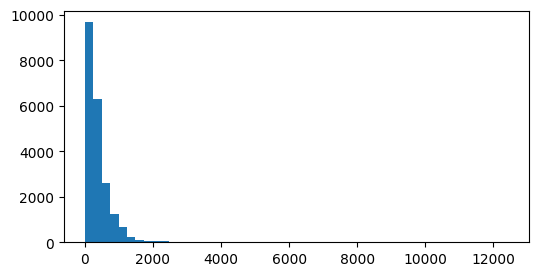

In [ ]:
# visualise the data according to the 'Complaint' character length
plt.figure(figsize=(6,3))
doc_len = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_len, bins=50)

#### Find the top 40 words by frequency among all the articles after processing the text.

In [ ]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean.drop('complaint_POS_removed', axis = 1)

/tmp/ipython-input-2177529228.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,complaint_text,lemma,product,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection-Credit card debt,morning help chase debt verification statement validate debt mail month attempt debt information consumer chase account advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead,Credit card or prepaid card-General-purpose credit card or charge card,agent anniversary date change agent information order account change anniversary date agent mislead
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,"Credit reporting, credit repair services, or other personal consumer reports-Other personal consumer report",card report application identity consent service extend credit verify identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,try book xxxx xxxx ticket come offer apply ticket apply reward card information offer minute notify screen decision immediately contact xxxx refer chase bank immediately contact chase bank notification screen tell chase representative speak application deny state ask information xxxx offer explain approve credit offer apply

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_n_bigram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    '''
    vec.vocabulary_  ---> Python dictionary mapping n-grams to column indices.
    eg: {'credit card': 0, 'card payment': 1, 'payment failed': 2}, these are columns and their indices in the matrix [[1 1 1]]
    '''

    bag_of_words = vec.transform(text)
    '''
    bag_of_words -->  sparse matrix of counts.
    eg: [[1 1 1]] - row is document number, 3 columns = 3 bigrams (credit card, card payment, payment failed), value is the bigram frequesncy
    '''

    sum_words = bag_of_words.sum(axis=0)
    print(sum_words)
    '''
    axis=0 = column-wise operation (down the rows).
    → sum over rows, result = per column total (frequency of each n-gram in the entire data and not just one document).
    '''
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]


    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]


In [ ]:
top_30_unigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=1, top=30)
top_30_bigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=2, top=30)
top_30_trigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=3, top=30)

print('Top 10 bigrams:\n')
top_30_bigrams[:10]

[[ 1  1  1 ... 32  1  3]]
[[1 1 1 ... 1 1 1]]
[[1 1 1 ... 1 1 1]]
Top 10 bigrams:



[('credit card', np.int64(12698)),
 ('credit report', np.int64(3842)),
 ('chase credit', np.int64(3070)),
 ('customer service', np.int64(2941)),
 ('account chase', np.int64(2886)),
 ('chase bank', np.int64(2546)),
 ('chase account', np.int64(2354)),
 ('contact chase', np.int64(2013)),
 ('debit card', np.int64(1935)),
 ('account account', np.int64(1877))]

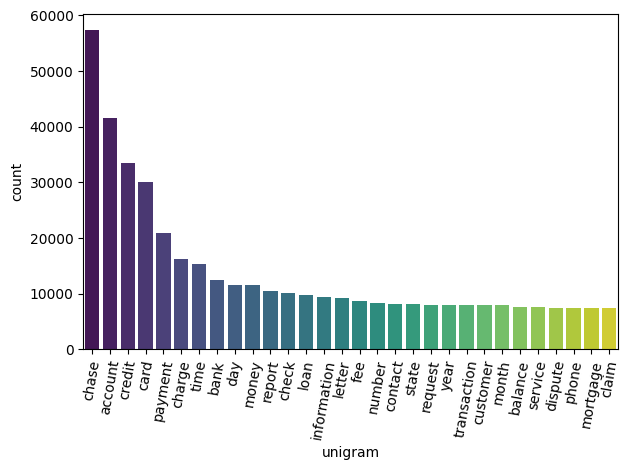

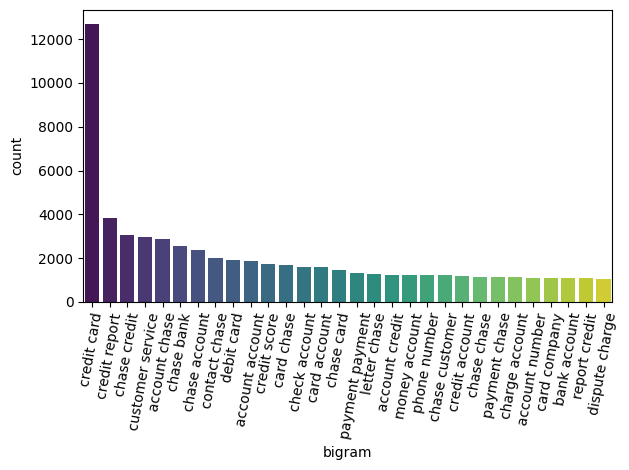

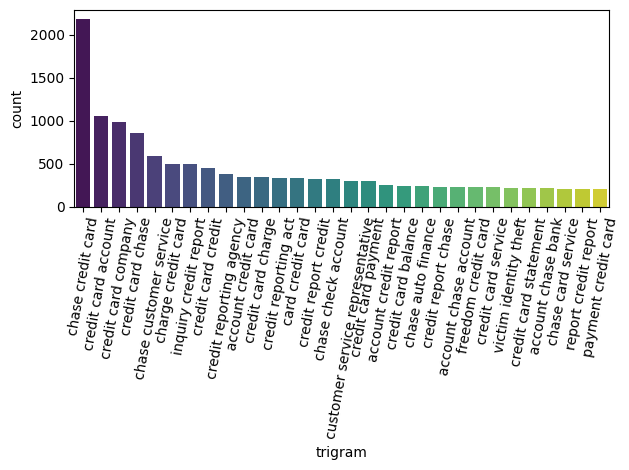

In [ ]:
df1 = pd.DataFrame(top_30_unigrams,  columns = ['unigram' , 'count'])
df2 = pd.DataFrame(top_30_bigrams,  columns = ['bigram' , 'count'])
df3 = pd.DataFrame(top_30_trigrams,  columns = ['trigram' , 'count'])

plt.figure()
fig = sns.barplot(x='unigram', y='count', data=df1, palette="viridis", hue='unigram', legend=False)
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

plt.figure()
fig = sns.barplot(x='bigram', y='count', data=df2, palette="viridis", hue='bigram', legend=False)
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

plt.figure()
fig = sns.barplot(x='trigram', y='count', data=df3, palette="viridis", hue='trigram', legend=False)
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

/tmp/ipython-input-619742717.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#initialise the TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words ='english')
'''
min_df : words that are present in less than 2 complaints are removed
max_df : words that are present in more than 95% of the complaints are removed
'''


'\nmin_df : words that are present in less than 2 complaints are removed\nmax_df : words that are present in more than 95% of the complaints are removed\n'

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
# create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean.Complaint_clean)
# document term frequency
'''
TF-IDF = Term Frequency – Inverse Document Frequency
It’s a numerical statistic used to reflect how important a word is to a document in a collection (corpus).
It balances two things:

How often a word appears in a document (TF)

How unique that word is across all documents (IDF)

1. TF (Term Frequency)
Measures how frequently a word appears in a document.
TF =Number of times term t appears in document d / Total number of terms in document d

2. IDF (Inverse Document Frequency)
Measures how important/rare a word is across all documents.
IDF=log(Total number of documents / 1+Number of documents containing t)

3. Final TF-IDF score = TF × IDF.	​

| Document | word1 | word2 | word3 | ... |
| -------- | ----- | ----- | ----- | --- |
| Doc1     | 0.4   | 0.0   | 0.6   | ... |
| Doc2     | 0.0   | 0.7   | 0.2   | ... |

'''

'\nTF-IDF = Term Frequency – Inverse Document Frequency\nIt’s a numerical statistic used to reflect how important a word is to a document in a collection (corpus).\nIt balances two things:\n\nHow often a word appears in a document (TF)\n\nHow unique that word is across all documents (IDF)\n\n1. TF (Term Frequency)\nMeasures how frequently a word appears in a document.\nTF =Number\xa0of\xa0times\xa0term\xa0t\xa0appears\xa0in\xa0document\xa0d / Total\xa0number\xa0of\xa0terms\xa0in\xa0document\xa0d\n\n2. IDF (Inverse Document Frequency)\nMeasures how important/rare a word is across all documents.\nIDF=log(Total\xa0number\xa0of\xa0documents / 1+Number\xa0of\xa0documents\xa0containing\xa0t)\n\n3. Final TF-IDF score = TF × IDF.\t\u200b\n\n| Document | word1 | word2 | word3 | ... |\n| -------- | ----- | ----- | ----- | --- |\n| Doc1     | 0.4   | 0.0   | 0.6   | ... |\n| Doc2     | 0.0   | 0.7   | 0.2   | ... |\n\n'

In [ ]:
display(tfidf.get_feature_names_out()[:5])
display(len(tfidf.get_feature_names_out()))

array(['aarp', 'abandonment', 'abate', 'abatement', 'abbreviation'],
      dtype=object)

6473

In [ ]:
# Display the document term matrix
display(dtm) # this is a SPARSE matrix, so will not show full data
dtm.toarray()
'''
columns are every word in all documents
rows are the document number
value is tf-idf score
'''


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 647178 stored elements and shape (21072, 6473)>

'\ncolumns are every word in all documents\nrows are the document number\nvalue is tf-idf score\n'

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [ ]:

'''
# Decomposition
# A module inside scikit-learn: sklearn.decomposition.
# Purpose: to reduce the dimensionality of data by decomposing(factoring) it into components.

# Common techniques available here:
    # PCA (Principal Component Analysis)
    # SVD
    # NMF (Non-Negative Matrix Factorization)
    # Dictionary Learning
'''

from sklearn.decomposition import NMF

## Manual Topic Modeling
This is  trial & error approach to find the best num of topics for  NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good  final topics are.

In [ ]:
#Load  nmf_model with the n_components
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [ ]:
# EXPLAINATION CELL, CAN SKIP IF YOU KNOW ABOUT NMF
'''
Take the document-term matrix from vectorization.
Factorize it into two (or more) matrices:
'''

X = np.array([[1,2,3],
              [4,5,6],
              [7,8,9]])
nmf_model2 = NMF(n_components=2, random_state=40)
w1 = nmf_model2.fit_transform(X)
print(w1)

'''
X becomes W(documents x components) * H (components * features)
'''


[[1.4455207  0.        ]
 [0.861917   0.72317499]
 [0.25554313 1.45260382]]


'\nX becomes W(documents x components) * H (components * features)\n'

In [ ]:
# How strongly a document belongs to a topic
w1 = nmf_model.fit_transform(dtm) # document-topic matrix (shape = n_docs × n_topics)

# weight of word in that topic
h1 = nmf_model.components_ #topic-word matrix (shape = n_topics × n_words)
print(len(h1[0]))
print(h1)
'''
Each row of h1 represents one topic.
The values are weights showing how strongly each word belongs to that topic.
'''


6473
[[4.40273385e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  3.40030989e-04 5.13434975e-05]
 [7.90559697e-03 0.00000000e+00 0.00000000e+00 ... 7.37036130e-04
  0.00000000e+00 1.84252852e-04]
 [0.00000000e+00 1.82290404e-04 7.77015967e-04 ... 0.00000000e+00
  2.60626349e-03 0.00000000e+00]
 [5.49133530e-03 4.85340771e-06 0.00000000e+00 ... 0.00000000e+00
  3.84376244e-03 6.66755378e-04]
 [2.23680198e-06 1.05350172e-03 1.07479274e-03 ... 1.43057021e-03
  3.28360114e-03 0.00000000e+00]]


'\nEach row of h1 represents one topic.\nThe values are weights showing how strongly each word belongs to that topic.\n'

In [ ]:
#Print the Top15 words for each of the topics
top_words = 15

all_vocab = np.array(tfidf.get_feature_names_out())

def top_words_per_topic(topic_vector): # topic_vector is 1 row from H1
   top_indices =  np.argsort(topic_vector)[::-1][:top_words]
   return [all_vocab[i] for i in top_indices]

top_words_each_topic = [top_words_per_topic(row) for row in h1]
topics = [' '.join(word_list) for word_list in top_words_each_topic]


In [ ]:
topics

['account check money chase deposit bank fund day branch transfer number transaction business claim customer',
 'credit card report inquiry chase account score company information debt limit application letter year use',
 'payment balance month pay statement fee day time auto credit chase date mortgage error year',
 'charge card fee dispute chase transaction purchase merchant claim service balance fraud statement time refund',
 'loan mortgage chase modification home property letter year document rate request time foreclosure sale information']

In [ ]:
w1 # doc * topic

array([[0.01640788, 0.01402769, 0.00657734, 0.00530228, 0.03359852],
       [0.00998323, 0.00192572, 0.00284078, 0.00383872, 0.0091318 ],
       [0.        , 0.05299147, 0.        , 0.        , 0.        ],
       ...,
       [0.01770225, 0.01441581, 0.        , 0.0232524 , 0.0151699 ],
       [0.00159178, 0.04762866, 0.10210737, 0.02623732, 0.00179653],
       [0.02854458, 0.03006178, 0.09700806, 0.00523654, 0.        ]])

In [ ]:
col = ['topic_' + str(col) for col in range(num_topics)]
row = ['doc_' + str(doc) for doc in range(len(df_clean.Complaint_clean))]
doc_to_topic = pd.DataFrame(np.round(w1,2), columns=col, index=row)

significant_topic = np.argmax(doc_to_topic.values, axis=1)
doc_to_topic['significant_topic' ] = significant_topic
'''
# here the values are how strongly that document belongs to a topic
'''
doc_to_topic

,topic_0,topic_1,topic_2,topic_3,topic_4,significant_topic
doc_0,0.02,0.01,0.01,0.01,0.03,4
doc_1,0.01,0.00,0.00,0.00,0.01,0
doc_2,0.00,0.05,0.00,0.00,0.00,1
doc_3,0.02,0.06,0.00,0.00,0.02,1
doc_4,0.07,0.00,0.00,0.00,0.01,0
...,...,...,...,...,...,...
doc_21067,0.00,0.07,0.02,0.06,0.00,1
doc_21068,0.01,0.01,0.00,0.03,0.02,3
doc_21069,0.02,0.01,0.00,0.02,0.02,0
doc_21070,0.00,0.05,0.10,0.03,0.00,2


In [ ]:
#Assign the best topic to each of the complaints in Topic Column

df_clean['Topic'] = significant_topic

/tmp/ipython-input-1505462894.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#Print the first 5 Complaint for each of the Topics
temp=df_clean.groupby('Topic').head(5)
temp.sort_values('Topic', inplace=True)
temp

/tmp/ipython-input-793734782.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,complaint_text,lemma,product,complaint_POS_removed,Complaint_clean,Topic
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead,Credit card or prepaid card-General-purpose credit card or charge card,agent anniversary date change agent information order account change anniversary date agent mislead,agent anniversary date change agent information order account change anniversary date agent mislead,0
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,grand son check deposit chase account fund clear chase bank close account pay money need speek grand son check clear money chase bank refuse pay money grand son chase time tell verify check owner country time date happen check number xxxx claim number xxxx chase,Checking or savings account-Checking account,son deposit chase account fund account money son money chase money son chase time check owner country time date check number claim number chase,son deposit chase account fund account money son money chase money son chase time check owner country time date check number claim number chase,0
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past t

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

topic_mapping = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(topic_mapping)

/tmp/ipython-input-4156676373.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_clean

,complaint_text,lemma,product,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection-Credit card debt,morning help chase debt verification statement validate debt mail month attempt debt information consumer chase account advance help,morning help chase debt verification statement validate debt mail month attempt debt information consumer chase account advance help,Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead,Credit card or prepaid card-General-purpose credit card or charge card,agent anniversary date change agent information order account change anniversary date agent mislead,agent anniversary date change agent information order account change anniversary date agent mislead,Bank Account services
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,"Credit reporting, credit repair services, or other personal consumer reports-Other personal consumer report",card report application identity consent service extend credit verify identity applicant,card report application identity consent service extend credit verify identity applicant,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though the

<Axes: xlabel='Topic', ylabel='count'>

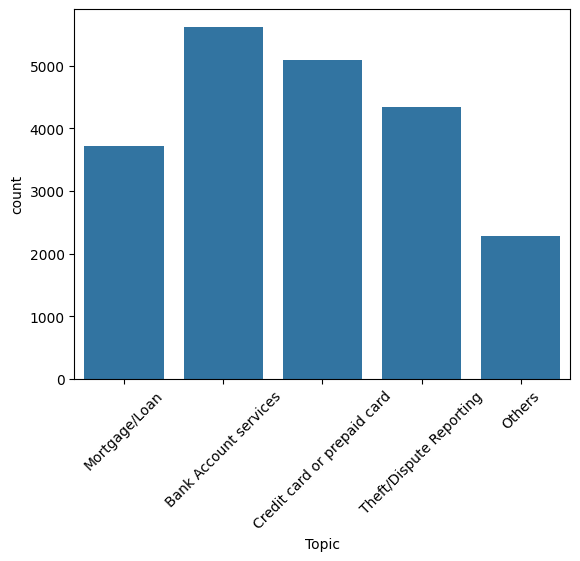

In [ ]:
# check for class imbalance
plt.xticks(rotation=45)
sns.countplot(x='Topic', data=df_clean)


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['Complaint_clean','Topic']]# ?? why one more bracket

In [ ]:
reverse_topic_mapping = {
    'Bank Account services' :0,
    'Credit card or prepaid card':1,
    'Others':2,
    'Theft/Dispute Reporting':3,
    'Mortgage/Loan':4
}
# topics should be number not text for training
training_data['Topic'] = training_data['Topic'].map(reverse_topic_mapping)

/tmp/ipython-input-3370537698.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

count_vect = CountVectorizer(stop_words = 'english')
'''
EXAMPLE
Doc1: "credit card not working"
Doc2: "loan payment issue"

converts to bag of words - raw count
         card  credit  issue  loan  not  payment  working
Doc1      1      1      0     0     1     0        1
Doc2      0      0      1     1     0     1        0
'''
X_vect= count_vect.fit_transform(training_data['Complaint_clean'])

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_vect)
'''
converts those raw counts into TF-IDF weighted values.
TfidfVectorizer (one step):  a shortcut that does both steps together (CountVectorizer → TfidfTransformer).

         card  credit  issue  loan  not  payment  working
Doc1    0.47   0.47   0.00   0.00  0.47   0.00     0.47
Doc2    0.00   0.00   0.58   0.58  0.00   0.58     0.00

Now instead of raw counts, you have weights:
Words common in many docs (like “not”) will get lower weight.
Words specific to a doc (like “credit” or “loan”) get higher weight.
'''

'\nconverts those raw counts into TF-IDF weighted values.\nTfidfVectorizer (one step):  a shortcut that does both steps together (CountVectorizer → TfidfTransformer).\n\n         card  credit  issue  loan  not  payment  working\nDoc1    0.47   0.47   0.00   0.00  0.47   0.00     0.47\nDoc2    0.00   0.00   0.58   0.58  0.00   0.58     0.00\n\nNow instead of raw counts, you have weights:\nWords common in many docs (like “not”) will get lower weight.\nWords specific to a doc (like “credit” or “loan”) get higher weight.\n'

In [ ]:
from sklearn.model_selection import train_test_split

Y = training_data['Topic']

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size = 0.25, random_state=40, stratify=Y)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# custom classification report
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay

def display_classification_report(model, metric):

    y_train_pred_proba = model.predict_proba(X_train)
    '''
    shape of X-train : shape (n_samples, n_classes)
    # predict_proba returns probability of the doc belonging to topic
    [[0.05, 0.90, 0.05], -> each row sums to 1
    [0.60, 0.10, 0.30]]
    '''
    y_test_pred_proba  = model.predict_proba(X_test)
    roc_auc_score_train = round(roc_auc_score(y_train, y_train_pred_proba,
                                             average='weighted', multi_class='ovr'), 2)
    roc_auc_score_test  = round(roc_auc_score(y_test,  y_test_pred_proba,
                                             average='weighted', multi_class='ovr'), 2) #mean weighted by class support (large classes count more).
    '''
    ROC curve (Receiver Operating Characteristic): plots TPR -
    true positive rate (recall/sensitivity) vs FPR-false positive rate
     as you sweep a threshold over model scores.
      TPR (Recall) = TP / (TP + FN)
      FPR = FP / (FP + TN)

    AUC (Area Under the ROC Curve): single number ∈ [0,1] measuring how well the model ranks positives above negatives.
    0.5 ≈ random, 1.0 = perfect.

    roc_auc_score:
    Builds an ROC curve for each class vs rest using the class’s column of probabilities,
    computes AUC, then weighted-averages by class frequencies.

    '''

    print("ROC AUC Score Train:", roc_auc_score_train)
    print("ROC AUC Score Test:", roc_auc_score_test)
    metric.append(roc_auc_score_train)
    metric.append(roc_auc_score_test)

    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)
    precision_train, recall_train, fscore_train, support_train = precision_recall_fscore_support(
        y_train, y_train_pred, average='weighted'
    )
    precision_test, recall_test, fscore_test, support_test = precision_recall_fscore_support(
        y_test, y_test_pred, average='weighted'
    )
    '''
    Precision = TP / (TP + FP)
    “Of what I predicted as this class, how many were correct?”

    Recall (TPR) = TP / (TP + FN)
    “Of all true items of this class, how many did I catch?”

    F1-score = harmonic mean of precision & recall
    F1 = 2⋅P⋅R/ P+R - Balances P and R; low if either is low.

    Accuracy = (TP + TN) / N
    “Overall fraction correct.” Can be misleading with class imbalance.
    '''

    acc_score_train = round(accuracy_score(y_train, y_train_pred), 2)
    acc_score_test  = round(accuracy_score(y_test,  y_test_pred), 2)

    metric.append(acc_score_train)
    metric.append(acc_score_test)
    metric.append(round(precision_train, 2))
    metric.append(round(precision_test, 2))
    metric.append(round(recall_train, 2))
    metric.append(round(recall_test, 2))
    metric.append(round(fscore_train, 2))
    metric.append(round(fscore_test, 2))
    print('Train Accuracy :', acc_score_train)
    print('Test Accuracy :',  acc_score_test)

    model_report_train = classification_report(y_train, y_train_pred)
    model_report_test  = classification_report(y_test,  y_test_pred)

    print('Classification Report for Train:\n', model_report_train)
    print('Classification Report for Test:\n',  model_report_test)

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(12, 8))
    cm  = confusion_matrix(y_test, y_test_pred)
    '''
    Confusion Matrix (multiclass)- A table: rows = true class, columns = predicted class (in
    '''
    cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    cmp.plot(ax=ax)
    plt.xticks(rotation=80)
    plt.show();


ROC AUC Score Train: 0.97
ROC AUC Score Test: 0.96
Train Accuracy : 0.78
Test Accuracy : 0.75
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.75      0.92      0.82      4218
           1       0.74      0.87      0.80      3818
           2       0.99      0.15      0.27      1715
           3       0.84      0.80      0.82      3261
           4       0.83      0.82      0.83      2792

    accuracy                           0.78     15804
   macro avg       0.83      0.71      0.71     15804
weighted avg       0.81      0.78      0.76     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.72      0.90      0.80      1406
           1       0.70      0.85      0.77      1272
           2       0.94      0.10      0.19       572
           3       0.80      0.76      0.78      1087
           4       0.83      0.79      0.81       931

    accuracy            

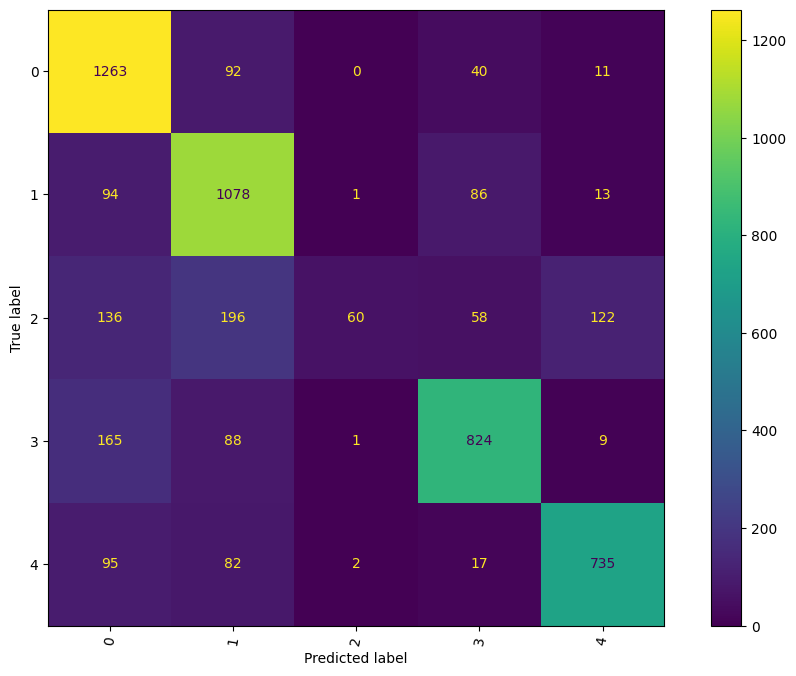

In [ ]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train, y_train)
metric1=[]
display_classification_report(mnb,metric1)


ROC AUC Score Train: 1.0
ROC AUC Score Test: 1.0
Train Accuracy : 0.97
Test Accuracy : 0.95
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      4218
           1       0.97      0.98      0.98      3818
           2       0.99      0.95      0.97      1715
           3       0.98      0.97      0.97      3261
           4       0.98      0.96      0.97      2792

    accuracy                           0.97     15804
   macro avg       0.98      0.97      0.97     15804
weighted avg       0.97      0.97      0.97     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      1406
           1       0.94      0.97      0.96      1272
           2       0.99      0.90      0.95       572
           3       0.95      0.96      0.95      1087
           4       0.95      0.92      0.93       931

    accuracy              

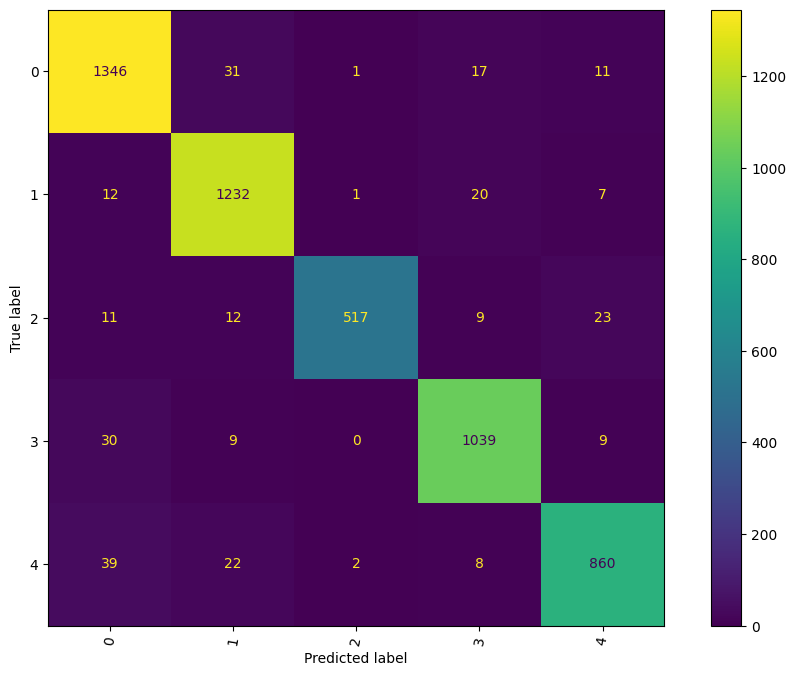

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=40, solver='liblinear')
log_reg.fit(X_train, y_train)
metric2=[]
display_classification_report(log_reg,metric2)




ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.89
Train Accuracy : 1.0
Test Accuracy : 0.83
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4218
           1       1.00      1.00      1.00      3818
           2       1.00      1.00      1.00      1715
           3       1.00      1.00      1.00      3261
           4       1.00      1.00      1.00      2792

    accuracy                           1.00     15804
   macro avg       1.00      1.00      1.00     15804
weighted avg       1.00      1.00      1.00     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.84      0.83      0.84      1406
           1       0.83      0.86      0.85      1272
           2       0.82      0.82      0.82       572
           3       0.83      0.82      0.82      1087
           4       0.83      0.82      0.82       931

    accuracy              

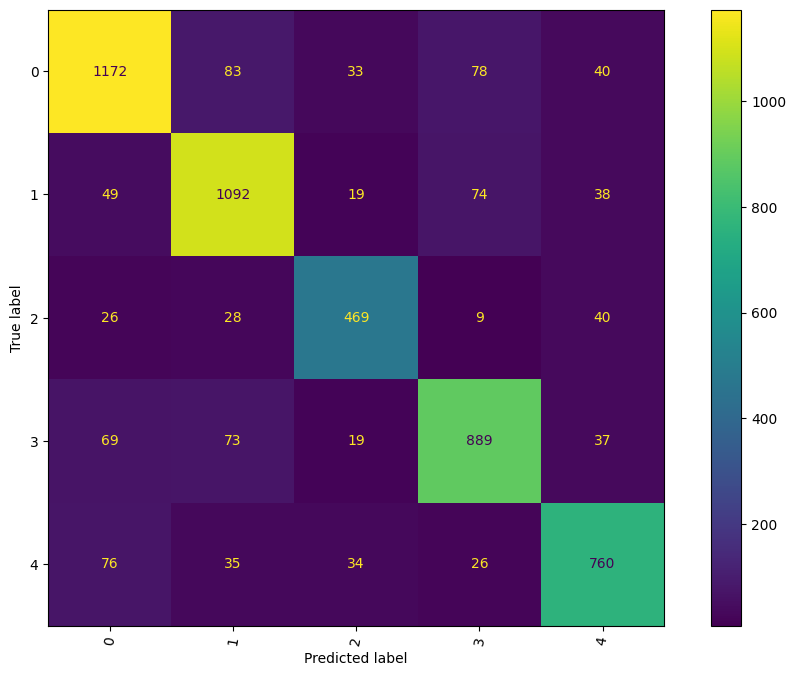

In [ ]:
# decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=40)
dt.fit(X_train, y_train)
metric3=[]
display_classification_report(dt,metric3)


OOB SCORE : 0.8621867881548975
ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.99
Train Accuracy : 1.0
Test Accuracy : 0.87
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4218
           1       1.00      1.00      1.00      3818
           2       1.00      1.00      1.00      1715
           3       1.00      1.00      1.00      3261
           4       1.00      1.00      1.00      2792

    accuracy                           1.00     15804
   macro avg       1.00      1.00      1.00     15804
weighted avg       1.00      1.00      1.00     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89      1406
           1       0.85      0.92      0.89      1272
           2       0.97      0.60      0.74       572
           3       0.88      0.88      0.88      1087
           4       0.88      0.87      0.88       

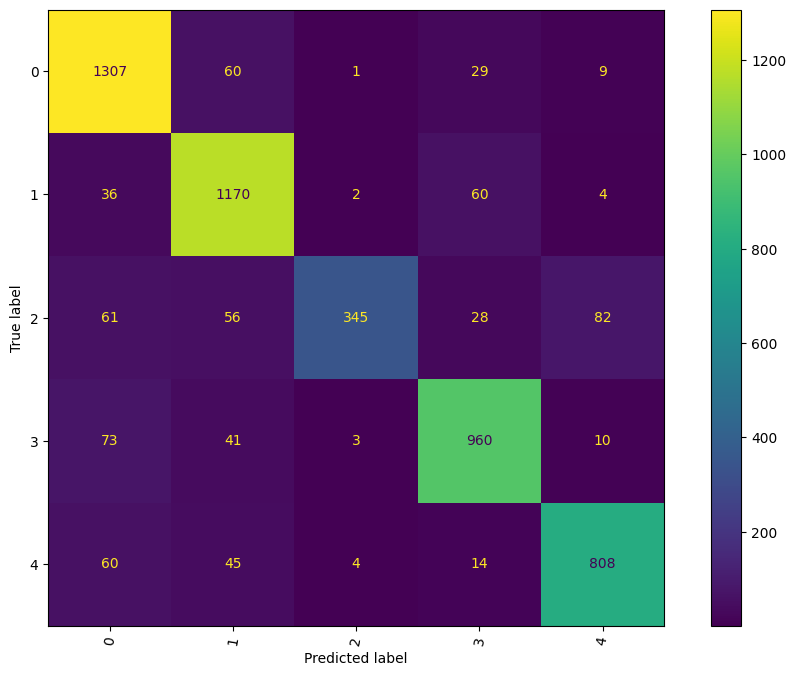

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest Classification

rf = RandomForestClassifier(n_estimators = 500,random_state=40, n_jobs = -1,oob_score=True)
# fit model
rf.fit(X_train,y_train)

# oob score
print('OOB SCORE :',rf.oob_score_)
metric4=[]
display_classification_report(rf,metric4)


# **Hyper Parameter tuning with GridSearchCV**

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)
# shuffles data before creating folds
'''
 StratifiedKFold :  Every fold has the same class distribution as the original dataset.
Example:
If your dataset is:
70% class A
30% class B

Then each fold will also be:
70% A
30% B
'''

def grid_search(model, folds, params, scoring=None):
    return GridSearchCV(model, n_jobs=-1, verbose=True,cv=folds, param_grid=params, scoring=scoring)

def print_best_score_params(model):
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score:  0.7768289757687642
Best Hyperparameters:  {'alpha': 0.1}
ROC AUC Score Train: 0.98
ROC AUC Score Test: 0.95
Train Accuracy : 0.85
Test Accuracy : 0.78
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      4218
           1       0.82      0.88      0.85      3818
           2       0.90      0.63      0.74      1715
           3       0.85      0.86      0.86      3261
           4       0.89      0.87      0.88      2792

    accuracy                           0.85     15804
   macro avg       0.86      0.83      0.84     15804
weighted avg       0.86      0.85      0.85     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.79      0.85      0.82      1406
           1       0.75      0.82      0.78      1272
           2       0.78      0.45      0.57       572
   

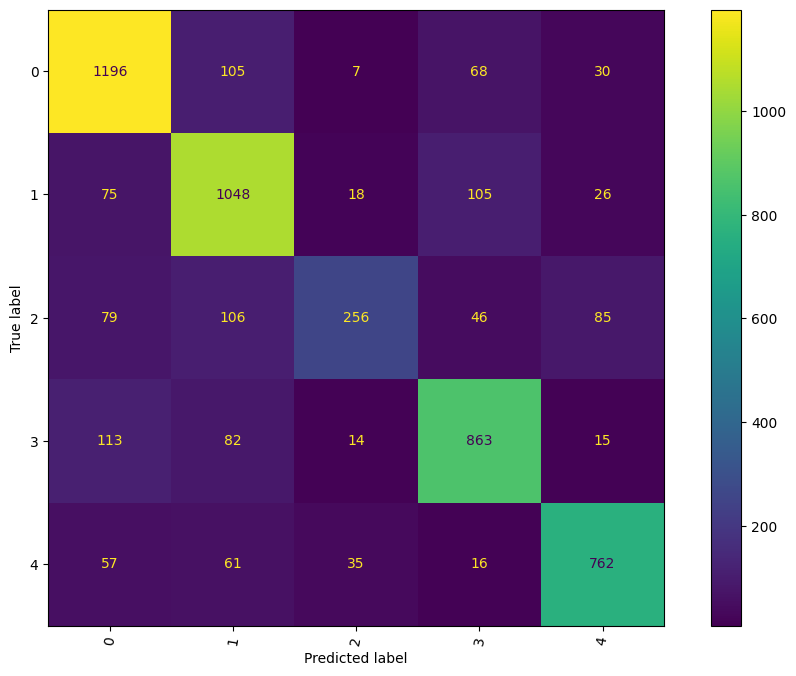

In [ ]:
mnb = MultinomialNB()

grid_search_mnb = grid_search(mnb, folds,{'alpha': (1, 0.1, 0.01, 0.001, 0.0001)})
grid_search_mnb.fit(X_train, y_train)

metric5=[]
print_best_score_params(grid_search_mnb)
display_classification_report(grid_search_mnb,metric5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:


15 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solve

Best Score:  0.9589979737224642
Best Hyperparameters:  {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
ROC AUC Score Train: 0.98
ROC AUC Score Test: 0.95
Train Accuracy : 0.85
Test Accuracy : 0.78
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      4218
           1       0.82      0.88      0.85      3818
           2       0.90      0.63      0.74      1715
           3       0.85      0.86      0.86      3261
           4       0.89      0.87      0.88      2792

    accuracy                           0.85     15804
   macro avg       0.86      0.83      0.84     15804
weighted avg       0.86      0.85      0.85     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.79      0.85      0.82      1406
           1       0.75      0.82      0.78      1272
           2       0.78      0.45      0.57       572
           3       0.79      0.79 

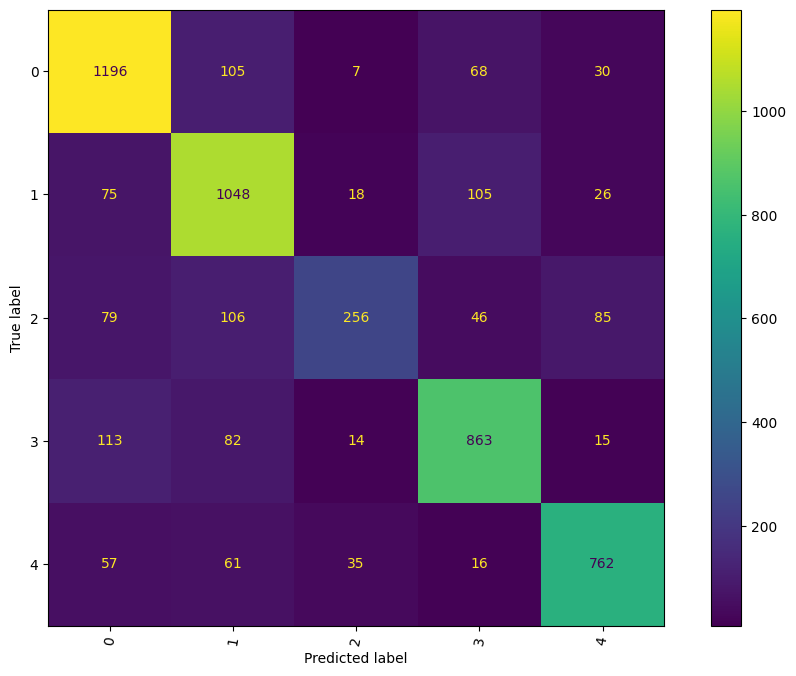

In [ ]:
log_reg = LogisticRegression()
grid_search_log_reg = grid_search(log_reg, folds, {'C': [0.01, 1, 10],
                                                   'penalty': ['l1', 'l2'],
                                                   'solver': ['liblinear','newton-cg','saga']
                                                  })
grid_search_log_reg.fit(X_train, y_train)
metric6=[]
print_best_score_params(grid_search_log_reg)
display_classification_report(grid_search_mnb,metric6)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Score:  0.9575747325920899
Best Hyperparameters:  {'max_depth': 20, 'min_samples_leaf': 30}
ROC AUC Score Train: 0.98
ROC AUC Score Test: 0.96
Train Accuracy : 0.85
Test Accuracy : 0.83
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85      4218
           1       0.85      0.89      0.87      3818
           2       0.87      0.82      0.85      1715
           3       0.85      0.82      0.84      3261
           4       0.83      0.85      0.84      2792

    accuracy                           0.85     15804
   macro avg       0.85      0.85      0.85     15804
weighted avg       0.85      0.85      0.85     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83      1406
           1       0.81      0.86      0.84      1272
           2       0.84      

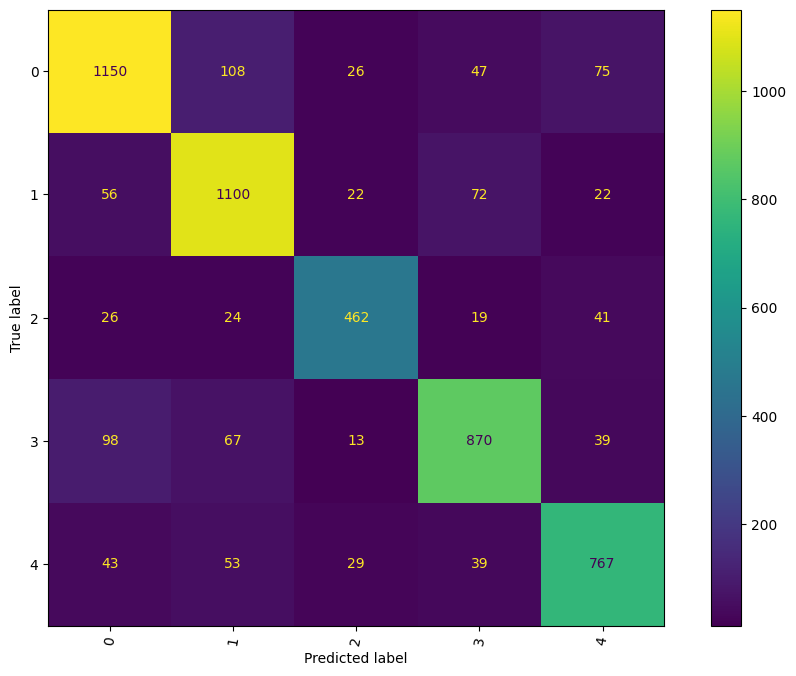

In [ ]:
dec_tree = DecisionTreeClassifier(random_state=40)

grid_search_dec_tree = grid_search(dec_tree, folds, {'max_depth':[5,10,20,30], 'min_samples_leaf':[5,10,20,30]}, scoring='roc_auc_ovr')
grid_search_dec_tree.fit(X_train, y_train)
metric7 = []
print_best_score_params(grid_search_dec_tree)
display_classification_report(grid_search_dec_tree,metric7)

In [ ]:
rfc = RandomForestClassifier(random_state=40, n_jobs = -1,oob_score=True)

# hyperparameters for Random Forest
rfc_params = {'max_depth': [10,20,30,40],
          'min_samples_leaf': [5,10,15,20,30],
          'n_estimators': [100,200,500,700]
        }

grid_search_rfc = grid_search(rfc, folds, rfc_params, scoring='roc_auc_ovr')
grid_search_rfc.fit(X_train, y_train)
metric8 = []
print_best_score_params(grid_search_rfc)
display_classification_report(grid_search_rfc,metric7)

In [ ]:
metric_table = pd.Dataframe({'Metric':['ROC_AUC Score(Train)','ROC_AUC Score(Test)',
                                    'Accuracy(Train)','Accuracy(Test)',
                                    'Precision(Train)','Precision(Test)',
                                    'Recall(Train)','Recall(Test)',
                                    'F1-Score(Train)','F1-Score(Test)'
                                  ],
                            'Multinomial Naive Bayes':metric1,
                            'Logistic Regression':metric2,
                            'Decision Tree Classifier':metric3,
                            'Random Forest Classifier':metric4,
                            'GridSearch MNB':metric5,
                            'GridSearch Log Reg':metric6,
                            'GridSearch Dec Tree':metric7,
                            'GridSearch Ran Forest':metric8}).set_index('Metric')

Logistic Regression with Grid search is working the best at classification

In [ ]:
# function to predict classgiven a text

def predict_class(text):

    text = clean_text(text)
    text = lemmatizer(text)
    text = extract_pos_tags(text)
    test = count_vect.transform([text])
    test_tfidf = tfidf_transformer.transform(test)

    prediction = grid_search_log_reg.predict(test_tfidf)
    return topic_mapping[prediction]


In [ ]:
complaint = ''
predicted_label = predict_class(text)
print(predicted_label)